In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime


/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_path = '../../Smart attack Algorithm/data/Car Hacking Dataset/'
benign_data_path = os.path.join(data_path, 'benign_data.csv')
attack_data_path = os.path.join(data_path, 'DoS_dataset.csv')

In [3]:
benign_data = pd.read_csv(benign_data_path)

benign_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,0350,8,052884666d0000a2,0
1,1.479121e+09,02c0,8,1400000000000000,0
2,1.479121e+09,0430,8,0000000000000000,0
3,1.479121e+09,04b1,8,0000000000000000,0
4,1.479121e+09,01f1,8,0000000000000000,0


In [4]:
def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['DLC'] == dlc, df.columns[3:]] = df.loc[df['DLC'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df
    

def read_ch_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'label']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['Payload'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
        
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    data = data[['Timestamp', 'ID','DLC','Payload', 'IAT', 'label']]
    data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
    
    return data

attack_data = read_ch_data(attack_data_path)
attack_data.head()

/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_18069/610449901.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_18069/610449901.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

,Timestamp,ID,DLC,Payload,IAT,label
0,1.478198e+09,0316,8,052168092121006f,0.000000,0
1,1.478198e+09,018f,8,fe5b0000003c0000,0.000209,0
2,1.478198e+09,0260,8,19212230088e6d3a,0.000228,0
3,1.478198e+09,02a0,8,64009a1d9702bd00,0.000232,0
4,1.478198e+09,0329,8,40bb7f1411200014,0.000237,0


In [5]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [5]:
hex_to_dec = lambda x: int(x, 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

hex_to_dec = lambda x: int(x, 16)

# Function to handle conversion
def convert_hex_column(column):
    def convert_value(value):
        try:
            # Try to convert using hex_to_dec
            return hex_to_dec(value)
        except ValueError:
            # If ValueError occurs, it means the value is in scientific notation
            return int(float(value))
    
    return column.apply(convert_value)


benign_data = transform_data(benign_data)


In [6]:
benign_data.shape

(988871, 5)

In [7]:
# data_len(benign_data)

In [7]:
attack_data = transform_data(attack_data)
attack_data.head()

,Timestamp,ID,DLC,Payload,IAT,label
0,1.478198e+09,790,8,369691032840896623,0.000000,0
1,1.478198e+09,399,8,18328243108518297600,0.000209,0
2,1.478198e+09,608,8,1810766114876976442,0.000228,0
3,1.478198e+09,672,8,7205928855671061760,0.000232,0
4,1.478198e+09,809,8,4664461563235663892,0.000237,0


In [10]:
data_len(attack_data)

'00:47:12:669'

In [8]:
def split_into_windows(df, window_size):
    """
    Split dataset into windows of a given size and assign a label to each window.
    
    Args:
        df (pd.DataFrame): Input dataframe.
        window_size (float): Window size in seconds.
        
    Returns:
        list: List of windowed dataframes.
        list: List of labels for each window (1 if any data point in the window is 1, else 0).
        int: Number of windows.
    """
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    windows = []
    window_labels = []  # To store the label for each window
    current_time = start_time
    
    while current_time <= end_time:
        # Extract data for the current window
        window = df[(df['Timestamp'] >= current_time) & 
                    (df['Timestamp'] < current_time + window_size)]
        
        if not window.empty:
            windows.append(window)
            
            # Assign window label: 1 if any label is 1 in the window, else 0
            if (window['label'] == 1).any():
                window_labels.append(1)
            else:
                window_labels.append(0)
        
        # Move to next window
        current_time += window_size
    
    return windows, window_labels, len(windows)

def calculate_entropy(windows):
    """
    Calculate entropy for each window.
    
    Args:
        windows (list): List of windowed dataframes.
        
    Returns:
        list: List of entropy values for each window.
    """
    entropies = []
    
    for window in windows:
        # Count unique combinations of Identifier, Data Length Code, and Data
        counts = window.groupby(['ID', 'DLC', 'Payload']).size()
        total = counts.sum()
        
        if total > 0:
            # Compute probability
            probabilities = counts / total
            
            # Calculate entropy using the definition
            entropy = -np.sum(probabilities * np.log2(probabilities))
            entropies.append(entropy)
    
    return entropies

In [18]:
train_entropy_dict = {}  # Dictionary to store entropy values by window size
train_window_labels_dict = {}  # Stores window labels by window size

test_entropy_dict = {}  
test_window_labels_dict = {}  

window_sizes = [0.1, 0.5, 1]  # in seconds

for window_size in window_sizes:

    # Split attack_data into 2 parts, 30% for training, rest for testing
    data_train, data_test = train_test_split(attack_data, test_size=0.3, shuffle=False)
    ## From data_train, select only those having label 0
    data_train = data_train[data_train['label'] == 0]
    data_train, data_test = data_train.reset_index(drop=True), data_test.reset_index(drop=True)

    train_windows, train_window_labels, train_num_windows = split_into_windows(data_train, window_size)
    train_entropies = calculate_entropy(train_windows)
    
    # Store entropy values in dictionary
    train_entropy_dict[window_size] = train_entropies
    train_window_labels_dict[window_size] = train_window_labels
    
    print(f"Window size: {window_size} seconds")
    print(f"Number of training windows: {train_num_windows}")
    print(f"Average entropy: {np.mean(train_entropies):.4f}\n")

    ##Repeat the same for benign_data_val

    test_windows, test_window_labels, test_num_windows = split_into_windows(data_test, window_size)
    test_entropies = calculate_entropy(test_windows)

    test_entropy_dict[window_size] = test_entropies
    test_window_labels_dict[window_size] = test_window_labels

    print(f"Window size: {window_size} seconds")
    print(f"Number of testing windows: {test_num_windows}")
    print(f"Average entropy: {np.mean(test_entropies):.4f}\n")
    
# Example: Access entropy values later
# print(entropy_dict[1])  # Entropy values for window size 1 second



def plot_entropy(entropy_dict, window_labels_dict, show_labels=True, title = None):
    """
    Plots entropy across time windows. If show_labels is True, creates separate plots 
    for each window size, distinguishing attack (label=1) and benign (label=0) windows.

    Args:
        entropy_dict (dict): Dictionary mapping window size to entropy values.
        window_labels_dict (dict): Dictionary mapping window size to window labels.
        show_labels (bool): Whether to plot attack and benign windows separately.
    """
    
    if show_labels:
        for window_size, entropies in entropy_dict.items():
            labels = window_labels_dict[window_size]
            x = np.arange(len(entropies))  # X-axis: Window indices
            
            attack_indices = [idx for idx, lbl in enumerate(labels) if lbl == 1]
            benign_indices = [idx for idx, lbl in enumerate(labels) if lbl == 0]

            plt.figure(figsize=(10, 5))
            
            plt.scatter(attack_indices, [entropies[idx] for idx in attack_indices], 
                        color='red', label='Attack', marker='x')

            plt.scatter(benign_indices, [entropies[idx] for idx in benign_indices], 
                        color='blue', label='Benign', marker='o')

            plt.title(f'Entropy Across Time Windows - Window Size {window_size}s')
            plt.xlabel('Window Index')
            plt.ylabel('Entropy')
            plt.legend()
            plt.grid(True)
            plt.show()

    else:
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'green', 'red']  # Colors for each window size
        
        for i, (window_size, entropies) in enumerate(entropy_dict.items()):
            x = np.arange(len(entropies))  # X-axis: Window indices
            plt.plot(x, entropies, label=f'Window size: {window_size}s', 
                     color=colors[i % len(colors)], marker='o', linestyle='-')

        #
        plt.xlabel('Window Index')
        plt.ylabel('Entropy')
        plt.legend()

        if title:
            plt.title(title)
        
        plt.grid(True)
        plt.show()

Window size: 0.1 seconds
Number of training windows: 21709
Average entropy: 5.0025

Window size: 0.1 seconds
Number of testing windows: 6391
Average entropy: 5.7267

Window size: 0.5 seconds
Number of training windows: 4343
Average entropy: 6.3284

Window size: 0.5 seconds
Number of testing windows: 1279
Average entropy: 6.6645

Window size: 1 seconds
Number of training windows: 2172
Average entropy: 6.7883

Window size: 1 seconds
Number of testing windows: 641
Average entropy: 7.0092



In [19]:
train_window_labels_dict

{0.1: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


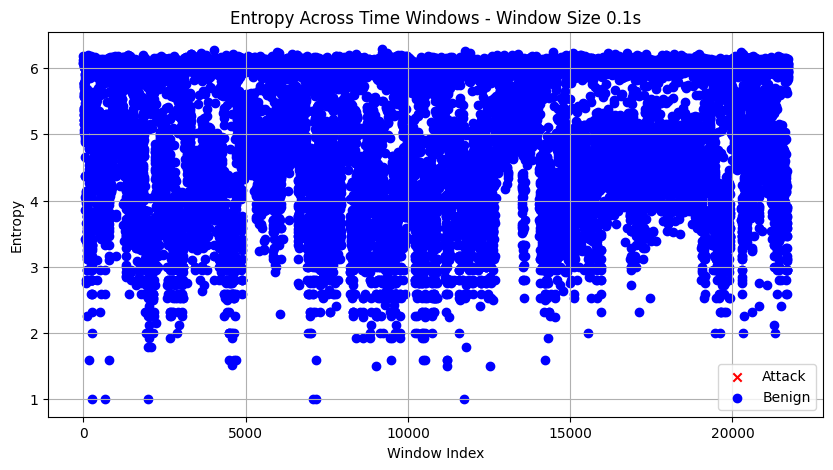

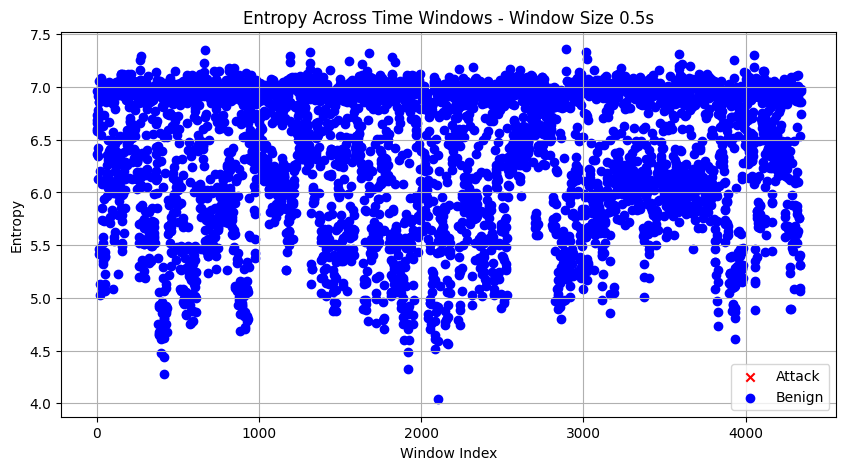

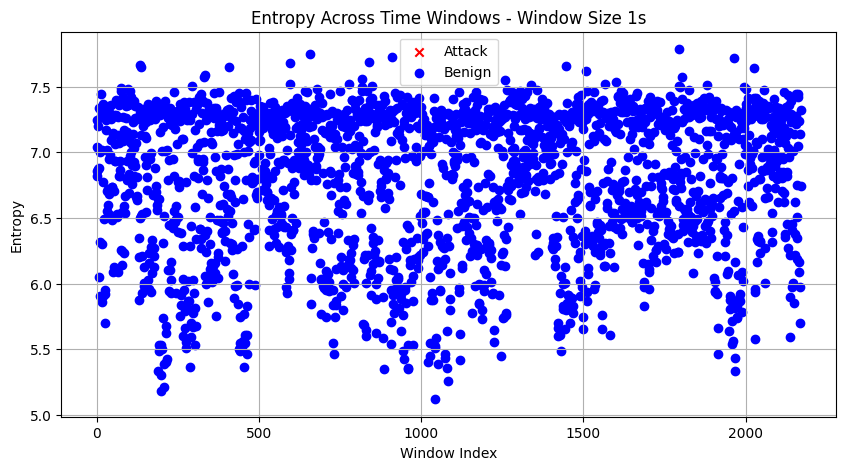

In [17]:
# # Plot entropy using stored data
plot_entropy(train_entropy_dict, train_window_labels_dict, show_labels=True, title = "Entropy by Window Size (Training Set)")

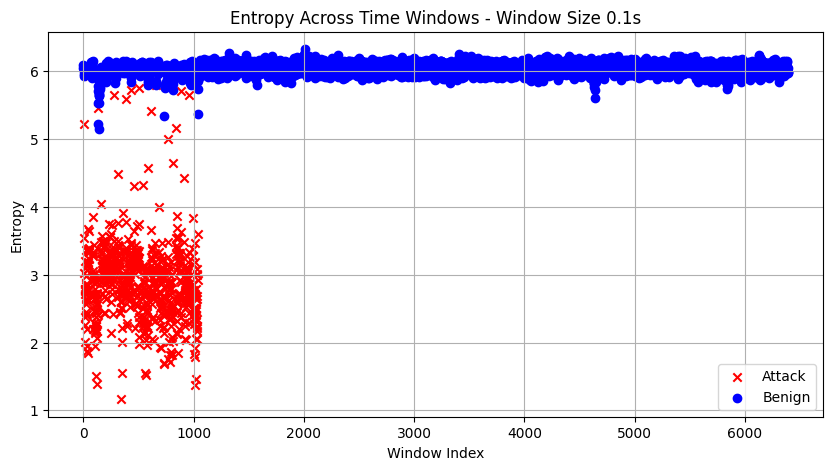

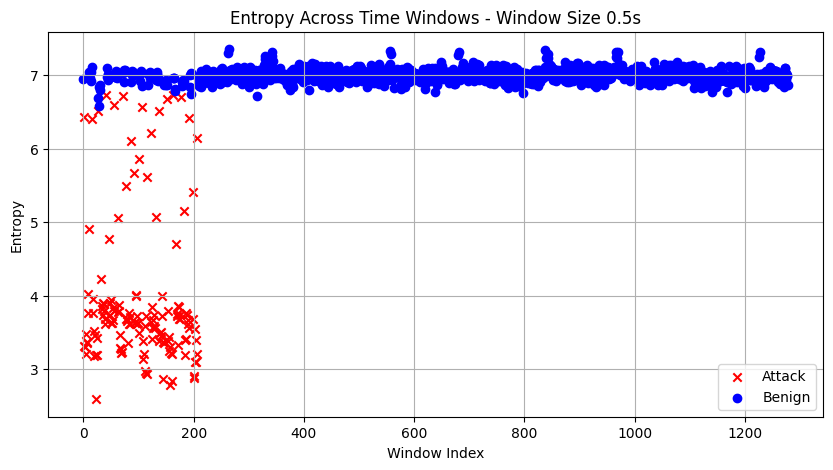

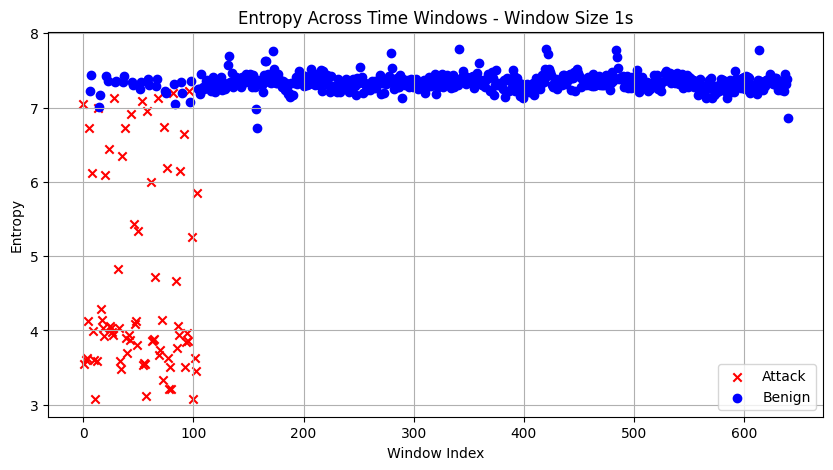

In [15]:
plot_entropy(test_entropy_dict, test_window_labels_dict, show_labels=True, title="Entropy by Window Size (Test Set)")

In [32]:
def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

In [ ]:
# ## Write code to find median and std dev of each window size from the training set

# mean_window_01, std_dev_window_01 = np.mean(train_entropy_dict[0.1]), np.std(train_entropy_dict[0.1])
# mean_window_05, std_dev_window_05 = np.mean(train_entropy_dict[0.5]), np.std(train_entropy_dict[0.5])
# mean_window_1, std_dev_window_1 = np.mean(train_entropy_dict[1]), np.std(train_entropy_dict[1])

# fp_dict = {0.1: None, 0.5: None, 1: None}  # Dictionary to store the first k where FP turns 0

# k_list = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]


# for k in k_list:

#     print("Currently on k =", k)

#     # Define thresholds
#     threshold_01 = [mean_window_01 - k * std_dev_window_01, mean_window_01 + k * std_dev_window_01]
#     threshold_05 = [mean_window_05 - k * std_dev_window_05, mean_window_05 + k * std_dev_window_05]
#     threshold_1 = [mean_window_1 - k * std_dev_window_1, mean_window_1 + k * std_dev_window_1]

#     # Get predictions
#     val_preds_01 = detect_attack(val_entropy_dict[0.1], threshold_01)
#     val_preds_05 = detect_attack(val_entropy_dict[0.5], threshold_05)
#     val_preds_1 = detect_attack(val_entropy_dict[1], threshold_1)

#     # Calculate false positives
#     num_false_positives_01 = sum((np.array(val_window_labels_dict[0.1]) == 0) & (np.array(val_preds_01) == 1))
#     num_false_positives_05 = sum((np.array(val_window_labels_dict[0.5]) == 0) & (np.array(val_preds_05) == 1))
#     num_false_positives_1 = sum((np.array(val_window_labels_dict[1]) == 0) & (np.array(val_preds_1) == 1))

#     print(f"Number of false positives for window size 0.1: {num_false_positives_01}")
#     print(f"Number of false positives for window size 0.5: {num_false_positives_05}")
#     print(f"Number of false positives for window size 1: {num_false_positives_1}\n")

#     # Track first k when false positives become zero
#     if num_false_positives_01 == 0 and fp_dict[0.1] is None:
#         fp_dict[0.1] = k
#     if num_false_positives_05 == 0 and fp_dict[0.5] is None:
#         fp_dict[0.5] = k
#     if num_false_positives_1 == 0 and fp_dict[1] is None:
#         fp_dict[1] = k

#     if num_false_positives_01 == 0 and num_false_positives_05 == 0 and num_false_positives_1 == 0:
#         print("All false positives are zero. Stopping the search.")
#         break

#     ## For all window sizes write code to plot ROC curve for k values
    

# print("First k values where false positives turn 0:", fp_dict)

Currently on k = 0.1
Number of false positives for window size 0.1: 2228
Number of false positives for window size 0.5: 451
Number of false positives for window size 1: 226

Currently on k = 0.2
Number of false positives for window size 0.1: 1933
Number of false positives for window size 0.5: 395
Number of false positives for window size 1: 201

Currently on k = 0.4
Number of false positives for window size 0.1: 1443
Number of false positives for window size 0.5: 268
Number of false positives for window size 1: 137

Currently on k = 0.5
Number of false positives for window size 0.1: 1216
Number of false positives for window size 0.5: 222
Number of false positives for window size 1: 108

Currently on k = 0.6
Number of false positives for window size 0.1: 1043
Number of false positives for window size 0.5: 181
Number of false positives for window size 1: 91

Currently on k = 0.8
Number of false positives for window size 0.1: 788
Number of false positives for window size 0.5: 130
Number o

In [ ]:
# ## Create a dictionary for mean and std dev for each window size
# mean_std_dict = {
#     0.1: (mean_window_01, std_dev_window_01),
#     0.5: (mean_window_05, std_dev_window_05),
#     1: (mean_window_1, std_dev_window_1)
# }

In [18]:
# test_entropy_dict = {}  # Dictionary to store entropy values by window size
# test_window_labels_dict = {}  # Stores window labels by window size

# window_sizes = [1, 0.5, 0.1]  # in seconds
# for window_size in window_sizes:
#     windows, window_labels, num_windows = split_into_windows(attack_data, window_size)
#     entropies = calculate_entropy(windows)
    
#     # Store entropy values in dictionary
#     test_entropy_dict[window_size] = entropies
#     test_window_labels_dict[window_size] = window_labels
    
#     print(f"Window size: {window_size} seconds")
#     print(f"Number of windows: {num_windows}")
#     print(f"Average entropy: {np.mean(entropies):.4f}\n")

#     #Write code to group by window label and print number of windows and average entropy by window label
#     # Group by window label
#     test_window_label_counts = pd.Series(window_labels).value_counts()
#     test_window_label_avg_entropy = pd.Series(entropies).groupby(window_labels).mean()
#     test_window_label_std_entropy = pd.Series(entropies).groupby(window_labels).std()
#     # print(window_label_counts)
#     # print(window_label_avg_entropy)
#     print("Number of attack windows: ", test_window_label_counts[1])
#     print("Number of benign windows: ", test_window_label_counts[0])
#     print()
#     print(f"Mean and std-dev of entropy for attack windows: {test_window_label_avg_entropy[1]} and {test_window_label_std_entropy[1]}")
#     print(f"Mean and std-dev of entropy for benign windows: {test_window_label_avg_entropy[0]} and {test_window_label_std_entropy[1]}") 
#     print('\n\n\n')


Window size: 1 seconds
Number of windows: 2811
Average entropy: 5.7464

Number of attack windows:  1677
Number of benign windows:  1134

Mean and std-dev of entropy for attack windows: 4.6781183332681096 and 1.2730382528863233
Mean and std-dev of entropy for benign windows: 7.326100830164048 and 1.2730382528863233




Window size: 0.5 seconds
Number of windows: 5622
Average entropy: 5.3873

Number of attack windows:  3051
Number of benign windows:  2571

Mean and std-dev of entropy for attack windows: 4.043447646186952 and 0.9897809214792238
Mean and std-dev of entropy for benign windows: 6.982081114458547 and 0.9897809214792238




Window size: 0.1 seconds
Number of windows: 28101
Average entropy: 4.5192

Number of attack windows:  14052
Number of benign windows:  14049

Mean and std-dev of entropy for attack windows: 3.0106291449736973 and 0.6440906335400842
Mean and std-dev of entropy for benign windows: 6.028056305337957 and 0.6440906335400842






In [34]:
test_entropy_dict

{}

In [33]:
plot_entropy(test_entropy_dict, test_window_labels_dict, show_labels=True) 

In [20]:
## Get indices where the below list has value 1
test_window_1_labels = test_window_labels_dict[1]
test_window05_labels = test_window_labels_dict[0.5]
test_window01_labels = test_window_labels_dict[0.1]

In [21]:
print("Length of window_1: ", len(test_window_1_labels))
print("Length of window05: ", len(test_window05_labels))
print("Length of window01: ", len(test_window01_labels))

Length of window_1:  2811
Length of window05:  5622
Length of window01:  28101


In [56]:
test_window_labels_dict

{1: [1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  

In [ ]:
# def evaluate(test_entropy_dict, test_window_labels_dict, mean_std_dict, fp_dict):

    
#     for window_size in test_entropy_dict.keys():
#         print("Currently on window size =", window_size)

#         # Define thresholds
#         mean, std_dev = mean_std_dict[window_size]
#         k = fp_dict[window_size]
#         threshold = [mean - k * std_dev, mean + k * std_dev]
#         print("Threshold: ", threshold)

#         # Get true labels
#         y_true = test_window_labels_dict[window_size]

#         # Get predictions
#         y_pred = detect_attack(test_entropy_dict[window_size], threshold)

#         accuracy = accuracy_score(y_true, y_pred)
#         print(f"Accuracy: {accuracy:.4f}")
#         print("\nClassification Report:\n", classification_report(y_true, y_pred))

#         ##Write code to find absolute number of true positives, false positives, true negatives and false negatives in comparison to actual positive and negative labels
#         true_positives = sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
#         false_positives = sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
#         true_negatives = sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
#         false_negatives = sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))

#         print(f"True Positives / All Positives : {true_positives} / {true_positives + false_negatives} ({true_positives / (true_positives + false_negatives):.4f})")
#         print(f"False Positives / All Negatives : {false_positives} / {false_positives + true_negatives} ({false_positives / (false_positives + true_negatives):.4f})")
#         print(f"True Negatives / All Negatives : {true_negatives} / {false_positives + true_negatives} ({true_negatives / (false_positives + true_negatives):.4f})")
#         print(f"False Negatives / All Positives : {false_negatives} / {true_positives + false_negatives} ({false_negatives / (true_positives + false_negatives):.4f})")
        
#         # Confusion Matrix
#         cm = confusion_matrix(y_true, y_pred)
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#         plt.title("Confusion Matrix")
#         plt.xlabel("Predicted")
#         plt.ylabel("True")
#         plt.show()

Currently on window size = 1
Threshold:  [7.0714225571171525, 9.660890039981524]
Accuracy: 0.9594

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1134
           1       1.00      0.94      0.96      1677

    accuracy                           0.96      2811
   macro avg       0.95      0.97      0.96      2811
weighted avg       0.96      0.96      0.96      2811

True Positives / All Positives : 1568 / 1677 (0.9350)
False Positives / All Negatives : 5 / 1134 (0.0044)
True Negatives / All Negatives : 1129 / 1134 (0.9956)
False Negatives / All Positives : 109 / 1677 (0.0650)


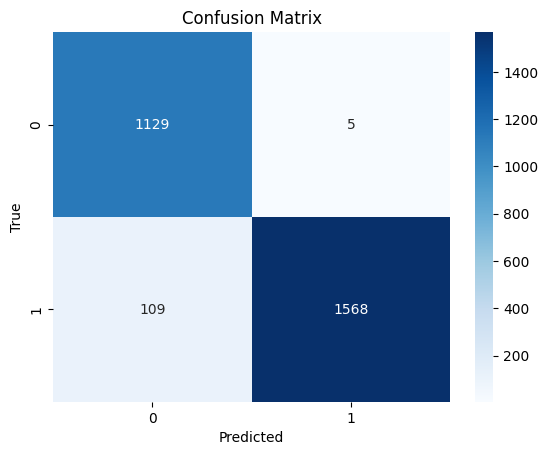

Currently on window size = 0.5
Threshold:  [6.7739137168617924, 8.829004050989969]
Accuracy: 0.9811

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2571
           1       0.99      0.98      0.98      3051

    accuracy                           0.98      5622
   macro avg       0.98      0.98      0.98      5622
weighted avg       0.98      0.98      0.98      5622

True Positives / All Positives : 2982 / 3051 (0.9774)
False Positives / All Negatives : 37 / 2571 (0.0144)
True Negatives / All Negatives : 2534 / 2571 (0.9856)
False Negatives / All Positives : 69 / 3051 (0.0226)


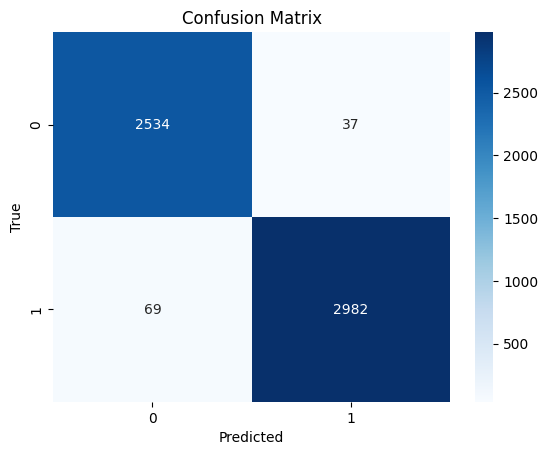

Currently on window size = 0.1
Threshold:  [4.987479288902709, 7.933022141587796]
Accuracy: 0.9904

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14049
           1       1.00      0.98      0.99     14052

    accuracy                           0.99     28101
   macro avg       0.99      0.99      0.99     28101
weighted avg       0.99      0.99      0.99     28101

True Positives / All Positives : 13784 / 14052 (0.9809)
False Positives / All Negatives : 3 / 14049 (0.0002)
True Negatives / All Negatives : 14046 / 14049 (0.9998)
False Negatives / All Positives : 268 / 14052 (0.0191)


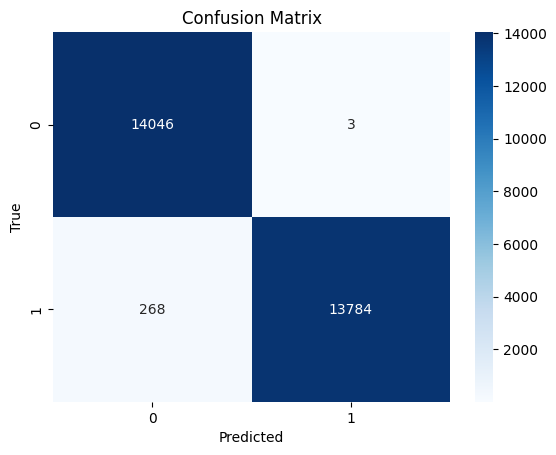

In [ ]:
# evaluate(test_entropy_dict, test_window_labels_dict, mean_std_dict, fp_dict)

In [23]:
train_entropy_dict

{0.1: [6.242110052776465,
  6.1741401710098796,
  6.1231218434371515,
  6.109331989581852,
  6.328075692310331,
  6.28705005128469,
  6.104436510390143,
  6.276793641028279,
  6.199125707552758,
  6.170870451120314,
  6.2619255444496105,
  6.202484794896623,
  6.169846189888418,
  6.1582325360089785,
  6.176231382185014,
  6.0463896056774065,
  6.235255869386692,
  6.127463305239749,
  6.215681585529378,
  6.259507438377464,
  6.213250642772004,
  6.182484104999752,
  6.176528928288314,
  6.259708067585963,
  6.233254025665855,
  6.317819282053921,
  6.278663015267257,
  6.315305307717137,
  6.328075692310332,
  6.263477838357187,
  6.343650749881641,
  6.383014377039546,
  6.46578133047149,
  6.450805561392745,
  6.304715915069595,
  6.361204110717407,
  6.3075628717975105,
  6.201045436242809,
  6.3163295689490315,
  6.328373238413631,
  6.504105777670662,
  6.387909856231257,
  6.393865032942694,
  6.526138668756296,
  6.598993238070897,
  6.384883751278524,
  6.480944263667545,
  6

In [26]:
train_window_labels_dict

{0.1: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [ ]:

attack_indices_1 = [idx for idx, lbl in enumerate(train_window_labels_dict[1]) if lbl == 1]
attack_indices_05 = [idx for idx, lbl in enumerate(train_window_labels_dict[0.5]) if lbl == 1]
attack_indices_01 = [idx for idx, lbl in enumerate(train_window_labels_dict[0.1]) if lbl == 1]

train_indices_1 = [idx for idx, lbl in enumerate(train_window) if lbl == 0]
train_indices_05 = [idx for idx, lbl in enumerate(train_window_05) if lbl == 0]
train_indices_01 = [idx for idx, lbl in enumerate(train_window_01) if lbl == 0]

In [ ]:
# ## Get the entropy values for the benign indices
# train_entropy_1 = [entropy_dict[1][i] for i in  benign_indices_1]
# train_entropy_05 = [entropy_dict[0.5][i] for i in  benign_indices_05]
# train_entropy_01 = [entropy_dict[0.1][i] for i in  benign_indices_01]

# ## Get the entropy values for the attack indices
# train_entropy_attack_1 = [entropy_dict[1][i] for i in  attack_indices_01]
# train_entropy_attack_05 = [entropy_dict[0.5][i] for i in  attack_indices_05]
# train_entropy_attack_01 = [entropy_dict[0.1][i] for i in  attack_indices_01]

# train_entropy_1_mean, train_entropy_1_std = np.mean(train_entropy_1), np.std(train_entropy_1)
# train_entropy_05_mean, train_entropy_05_std = np.mean(train_entropy_05), np.std(train_entropy_05)
# train_entropy_01_mean, train_entropy_01_std = np.mean(train_entropy_01), np.std(train_entropy_01)


# print(f"Window size: 1 second")
# print(f"Train entropy mean and std-dev: {train_entropy_1_mean:.4f}, {train_entropy_1_std:.4f}") 
# print('\n')
# print(f"Window size: 0.5 second")
# print(f"Train entropy mean and std-dev: {train_entropy_05_mean:.4f}, {train_entropy_05_std:.4f}")
# print('\n')
# print(f"Window size: 0.1 second")
# print(f"Train entropy mean and std-dev: {train_entropy_01_mean:.4f}, {train_entropy_01_std:.4f}")

Window size: 1 second
Train entropy mean and std-dev: 7.3115, 0.1026


Window size: 0.5 second
Train entropy mean and std-dev: 6.9681, 0.0974


Window size: 0.1 second
Train entropy mean and std-dev: 6.0110, 0.1280


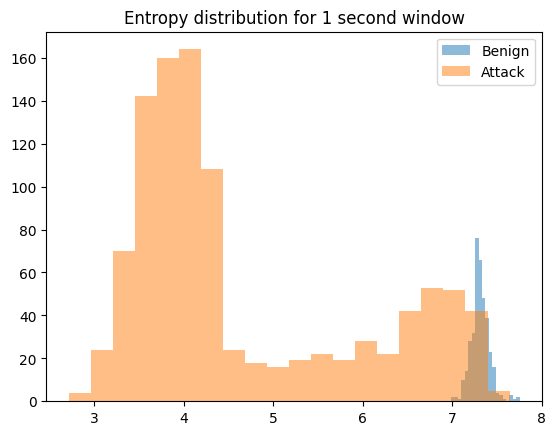

In [ ]:
# plt.hist(train_entropy_01, bins = 20, alpha = 0.5, label = 'Benign')
# plt.hist(train_entropy_attack_1, bins = 20, alpha = 0.5, label = 'Attack')
# plt.legend()
# plt.title('Entropy distribution for 1 second window')
# plt.show()

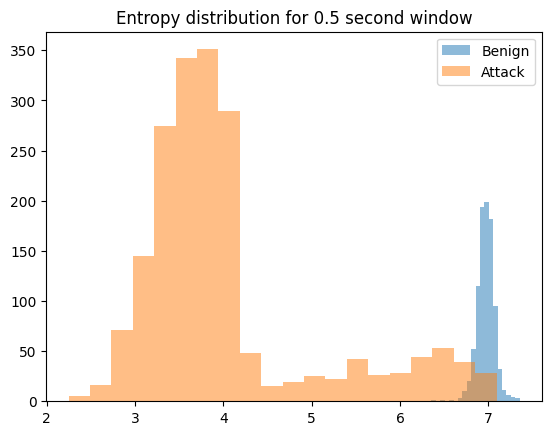

In [ ]:
# plt.hist(train_entropy_05, bins = 20, alpha = 0.5, label = 'Benign')
# plt.hist(train_entropy_attack_05, bins = 20, alpha = 0.5, label = 'Attack')
# plt.legend()
# plt.title('Entropy distribution for 0.5 second window')
# plt.show()

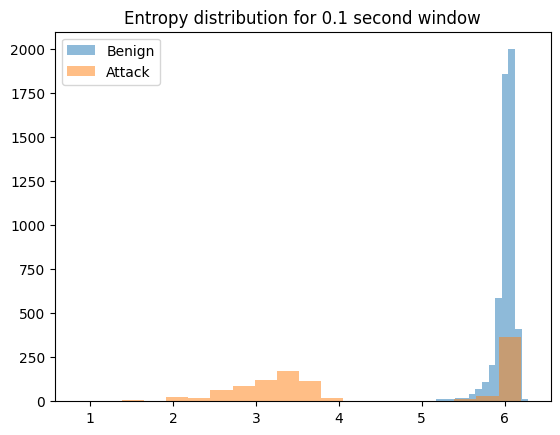

In [ ]:
# plt.hist(train_entropy_01, bins = 20, alpha = 0.5, label = 'Benign')
# plt.hist(train_entropy_attack_01, bins = 20, alpha = 0.5, label = 'Attack')
# plt.legend()
# plt.title('Entropy distribution for 0.1 second window')
# plt.show()

In [ ]:
test_attack_indices_1 = [idx for idx, lbl in enumerate(test_window1) if lbl == 1]
test_attack_indices_05 = [idx for idx, lbl in enumerate(test_window05) if lbl == 1]
attack_indices_01 = [idx for idx, lbl in enumerate(test_window_01) if lbl == 1]

test_benign_indices_1 = [idx for idx, lbl in enumerate(test_window1) if lbl == 0]
test_benign_indices_05 = [idx for idx, lbl in enumerate(test_window05) if lbl == 0]
test_benign_indices_01 = [idx for idx, lbl in enumerate(test_window_01) if lbl == 0]

train_benign_indices_1 = [idx for idx, lbl in enumerate(train_window1) if lbl == 0]
train_bengin_indices_05 = [idx for idx, lbl in enumerate(train_window05) if lbl == 0]
train_benign_indices_01 = [idx for idx, lbl in enumerate(train_window_01) if lbl == 0]

## Get the entropy values for the benign indices
train_entropy_1 = [entropy_dict[1][i] for i in  train_benign_indices_1]
train_entropy_05 = [entropy_dict[0.5][i] for i in  train_bengin_indices_05]
train_entropy_01 = [entropy_dict[0.1][i] for i in  train_benign_indices_01]

## Get the entropy values for the attack indices
entropy_attack_1 = [entropy_dict[1][i] for i in  attack_indices_1]
entropy_attack_05 = [entropy_dict[0.5][i] for i in  attack_indices_05]
entropy_attack_01 = [entropy_dict[0.1][i] for i in  attack_indices_01]

entropy_1_mean, entropy_1_std, entropy_attack_1_mean, entropy_attack_1_std = np.mean(entropy_1), np.std(entropy_1), np.mean(entropy_attack_1), np.std(entropy_attack_1)
entropy_05_mean, entropy_05_std, entropy_attack_05_mean, entropy_attack_05_std = np.mean(entropy_05), np.std(entropy_05), np.mean(entropy_attack_05), np.std(entropy_attack_05)
entropy_01_mean, entropy_01_std, entropy_attack_01_mean, entropy_attack_01_std = np.mean(entropy_01), np.std(entropy_01), np.mean(entropy_attack_01), np.std(entropy_attack_01)

In [24]:
## threshold = [mean - k*std_dev, mean + k*std_dev]


def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

k_vals = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3]

for k in k_vals:
    threshold_1 = [train_entropy_1_mean - k*train_entropy_1_std, train_entropy_1_mean + k*train_entropy_1_std]
    threshold_05 = [train_entropy_05_mean - k*train_entropy_05_std, train_entropy_05_mean + k*train_entropy_05_std] 
    threshold_01 = [train_entropy_01_mean - k*train_entropy_01_std, train_entropy_01_mean + k*train_entropy_01_std]
    
    print(f"Threshold for k = {k}")
    print('\n')

    print(f"Window size: 1 second")
    print(f"Threshold: {threshold_1}")

    predicted_labels = detect_attack(test_window_1, threshold_1)
    print("Accuracy:", accuracy_score(test_window1_labels, predicted_labels))
    print("classification Report")
    print(classification_report(test_window1_labels, predicted_labels))
    
    tn, fp, fn, tp = confusion_matrix(test_window1_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')


    print(f"Window size: 0.5 second")
    print(f"Threshold: {threshold_05}")

    predicted_labels = detect_attack(test_window_05, threshold_05)
    print("Accuracy", accuracy_score(test_window05_labels, predicted_labels))
    print("classification Report")
    print(classification_report(test_window05_labels, predicted_labels))

    tn, fp, fn, tp = confusion_matrix(test_window05_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')


    print(f"Window size: 0.1 second")
    print(f"Threshold: {threshold_01}")
    predicted_labels = detect_attack(test_window_01, threshold_01)
    print("Accuracy:",accuracy_score(test_window_01_labels, predicted_labels))
    print("classification Report")
    print(classification_report(test_window_01_labels, predicted_labels))

    tn, fp, fn, tp = confusion_matrix(test_window_01_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')


    print('\n\n\n\n')

Threshold for k = 0.1


Window size: 1 second
Threshold: [7.301276152742718, 7.32179784853099]
Accuracy: 0.5071123755334281
classification Report
              precision    recall  f1-score   support

           0       0.97      0.09      0.17       763
           1       0.48      1.00      0.65       643

    accuracy                           0.51      1406
   macro avg       0.73      0.55      0.41      1406
weighted avg       0.75      0.51      0.39      1406

True Positives (TP): 641 / 643 (Total Real Positives)
False Positives (FP): 691 / 643 (Total Real Positives)
True Negatives (TN): 72 / 763 (Total Real Negatives)
False Negatives (FN): 2 / 763 (Total Real Negatives)


Window size: 0.5 second
Threshold: [6.9583442018653185, 6.977819133719209]
Accuracy 0.4631803628601921
classification Report
              precision    recall  f1-score   support

           0       0.97      0.08      0.15      1642
           1       0.44      1.00      0.61      1169

    accuracy         

In [ ]:
def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

k_vals = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 9.5, 10]

best_accuracy_1 = 0
best_k_1 = 0
best_accuracy_05 = 0
best_k_05 = 0
best_accuracy_01 = 0
best_k_01 = 0

for k in k_vals:
    threshold_1 = [train_entropy_1_mean - k*train_entropy_1_std, train_entropy_1_mean + k*train_entropy_1_std]
    threshold_05 = [train_entropy_05_mean - k*train_entropy_05_std, train_entropy_05_mean + k*train_entropy_05_std] 
    threshold_01 = [train_entropy_01_mean - k*train_entropy_01_std, train_entropy_01_mean + k*train_entropy_01_std]
    
    print(f"Threshold for k = {k}")
    print('\n')

    print(f"Window size: 1 second")
    print(f"Threshold: {threshold_1}")

    predicted_labels = detect_attack(test_window_1, threshold_1)
    accuracy_1 = accuracy_score(test_window1_labels, predicted_labels)
    print("Accuracy:", accuracy_1)
    print("classification Report")
    print(classification_report(test_window1_labels, predicted_labels))
    
    if accuracy_1 > best_accuracy_1:
        best_accuracy_1 = accuracy_1
        best_k_1 = k

    tn, fp, fn, tp = confusion_matrix(test_window1_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')
    

    print(f"Window size: 0.5 second")
    print(f"Threshold: {threshold_05}")

    predicted_labels = detect_attack(test_window_05, threshold_05)
    accuracy_05 = accuracy_score(test_window05_labels, predicted_labels)
    print("Accuracy", accuracy_05)
    print("classification Report")
    print(classification_report(test_window05_labels, predicted_labels))
    if accuracy_05 > best_accuracy_05:
        best_accuracy_05 = accuracy_05
        best_k_05 = k


    tn, fp, fn, tp = confusion_matrix(test_window05_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')



    print(f"Window size: 0.1 second")
    print(f"Threshold: {threshold_01}")
    predicted_labels = detect_attack(test_window_01, threshold_01)
    accuracy_01 = accuracy_score(test_window_01_labels, predicted_labels)
    print("Accuracy:", accuracy_01)
    print("classification Report")
    print(classification_report(test_window_01_labels, predicted_labels))
    if accuracy_01 > best_accuracy_01:
        best_accuracy_01 = accuracy_01
        best_k_01 = k

    tn, fp, fn, tp = confusion_matrix(test_window_01_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_negatives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_positives} (Total Real Negatives)")
    print('\n')

    print('\n')

print(f"Best k value for window size 1 second: {best_k_1} with accuracy {best_accuracy_1}")
print(f"Best k value for window size 0.5 second: {best_k_05} with accuracy {best_accuracy_05}")
print(f"Best k value for window size 0.1 second: {best_k_01} with accuracy {best_accuracy_01}")

Threshold for k = 0.1


Window size: 1 second
Threshold: [7.301276152742718, 7.32179784853099]
Accuracy: 0.5071123755334281
classification Report
              precision    recall  f1-score   support

           0       0.97      0.09      0.17       763
           1       0.48      1.00      0.65       643

    accuracy                           0.51      1406
   macro avg       0.73      0.55      0.41      1406
weighted avg       0.75      0.51      0.39      1406

True Positives (TP): 641 / 643 (Total Real Positives)
False Positives (FP): 691 / 643 (Total Real Positives)
True Negatives (TN): 72 / 763 (Total Real Negatives)
False Negatives (FN): 2 / 763 (Total Real Negatives)


Window size: 0.5 second
Threshold: [6.9583442018653185, 6.977819133719209]
Accuracy 0.4631803628601921
classification Report
              precision    recall  f1-score   support

           0       0.97      0.08      0.15      1642
           1       0.44      1.00      0.61      1169

    accuracy         

In [26]:
data_path = '../../Smart Attack Algorithm/data/Car Hacking Dataset'

benign_data_path = os.path.join(data_path, 'benign_data.csv')
attack_data_path = os.path.join(data_path, 'DoS_dataset.csv')